# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import butter, filtfilt

/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Utils

In [5]:
def load_data(ticker="^GSPC", start_date='1990-01-02', end_date='2024-03-28', split_date='2023-01-01', apply_filter=False, debug=False):
    """ Load data, perform forward fill, optionally apply a Butterworth filter, and split into train and test. """
    # Download historical data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date)['Close']
    
    # Fill missing values and ensure all business days are accounted for
    all_business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    df = df.reindex(all_business_days).ffill()  # Forward filling the missing values
    if apply_filter:
        df = apply_butterworth_filter(df, debug=debug)

    if debug:
        print(f"Data loaded and forward filled. Total rows after forward fill: {len(df)}.")

    # Split the data into train and test sets
    split_point = pd.Timestamp(split_date)
    train_series = df[df.index < split_point]
    test_series = df[df.index >= split_point]
    return train_series, test_series

def apply_butterworth_filter(series, order=3, critical_frequency=0.05, debug=False):
    """ Applies a Butterworth filter to a given pandas Series. """
    b, a = butter(order, critical_frequency, btype='low', analog=False)
    filtered_values = filtfilt(b, a, series)
    filtered_series = pd.Series(filtered_values, index=series.index)
    if debug:
        print(" Butterworth filter applied.")
    return filtered_series

def train_model(train_series, use_gradient=False):
    if use_gradient:
        return gradient_descent(train_series)
    else:
        return linear_regression_without_gradient(train_series)


def get_mse(y_pred, y_real):
    return np.mean((y_real - y_pred) ** 2)

def linear_regression_without_gradient(train_series):
    N = len(train_series)
    x = pd.Series(range(N))
    y = train_series.reset_index(drop=True)
    
    x_mean = x.mean()
    y_mean = y.mean()
    
    b1 = ((x - x_mean) * (y - y_mean)).sum() / ((x - x_mean) ** 2).sum()
    b0 = y_mean - b1 * x_mean
    
    return b0, b1



################## NEEDS FIX
def get_mse_deriv(x, y, b0, b1):
    return np.mean((y-(b0+b1*x))**2)

def aprox_derivative(x, y, b0, b1, func=get_mse_deriv, derivate = 'b0'):
    delta = 0.1
    if derivate == 'b0':
        return (func(x,y,b0+delta,b1) - func(x,y,b0,b1))/delta
    elif derivate == 'b1':
        return (func(x,y,b0,b1+delta) - func(x,y,b0,b1))/delta

    raise Exception(f"Unkown derivate coef: {derivate}")
def gradient_descent(train_series, lr=1e-5, iterations=1000):
    N = len(train_series)
    x = pd.Series(range(N))
    y = train_series.reset_index(drop=True)
    
    b0 = np.random.randn()
    b1 = np.random.randn()
    
    prev_error = None
    for epoch in range(iterations):
        y_pred = b0 + b1 * x
        error = get_mse(y_pred, y)
        b0_grad = -2 * (y - y_pred).sum() / N
        b1_grad = -2 * (x * (y - y_pred)).sum() / N
        b0 -= lr * b0_grad
        b1 -= lr * b1_grad
        
        if epoch % 100 == 0 or epoch == iterations - 1:
            print(f"Epoch {epoch}:\n\tMSE={error}\n\tb0={b0}\n\tb1={b1}")
            print(f"\tb0_grad={b0_grad}\n\tb1_grad={b1_grad}")

        if prev_error and abs(prev_error - error) < 1e-6:
            print(f"Model converged at epoch {epoch}.")
            break
        
        prev_error = error

    print('-' * 50)
    return b0, b1
################## NEEDS FIX

def generate_predictions(train_series, test_series, start=None, end=None, debug=False):
    b0, b1 = linear_regression_without_gradient(train_series=train_series)
    start_date = start if start else test_series.index[0]
    end_date = end if end else test_series.index[-1]
    all_business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    if debug:
        print(f"Generating predictions between {start_date} and {end_date}\n\tb0 = {b0}\n\tb1 = {b1}")
    x = pd.Series(range(len(all_business_days)), index=all_business_days)
    predictions = b0 + b1 * x
    if debug:
        print(predictions.head())
        print(f" Forecast generated.")
    return predictions


def plot_predictions(test_series:pd.Series, prediction:pd.Series, title=""):
    prediction = prediction[prediction.index >= test_series.index[0]]
    plt.figure(figsize=(12, 6))
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_full_series(train_series:pd.Series, test_series:pd.Series, prediction:pd.Series, title=""):
    """ Plot the training data, test data, and Linear Regression predictions. """
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Train')
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed

 Butterworth filter applied.
Data loaded and forward filled. Total rows after forward fill: 8933.
324
Generating predictions between 1990-01-02 00:00:00 and 2024-03-28 00:00:00
	b0 = -3.0042832698256916
	b1 = 0.350057452101519
1990-01-02   -3.004283
1990-01-03   -2.654226
1990-01-04   -2.304168
1990-01-05   -1.954111
1990-01-08   -1.604053
Freq: B, dtype: float64
 Forecast generated.
MSE: 1940992.2951213908


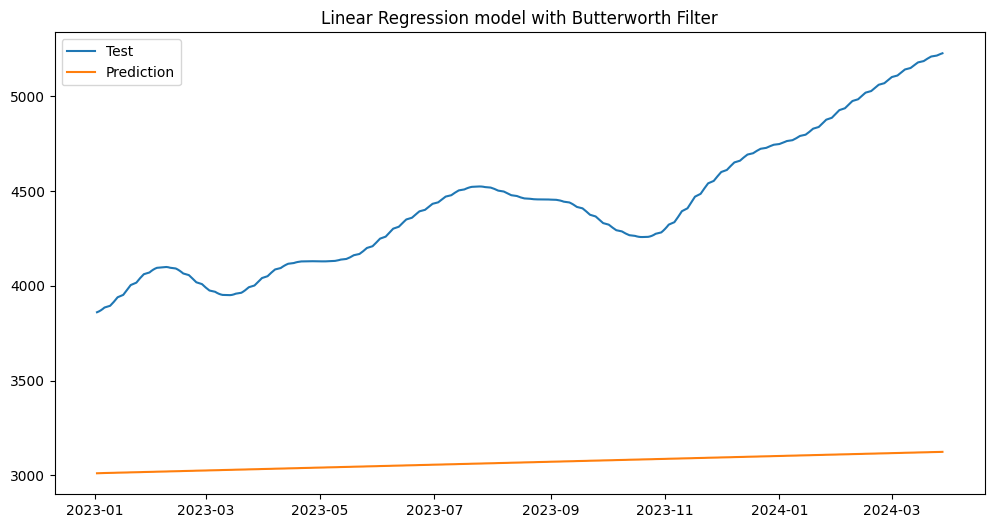

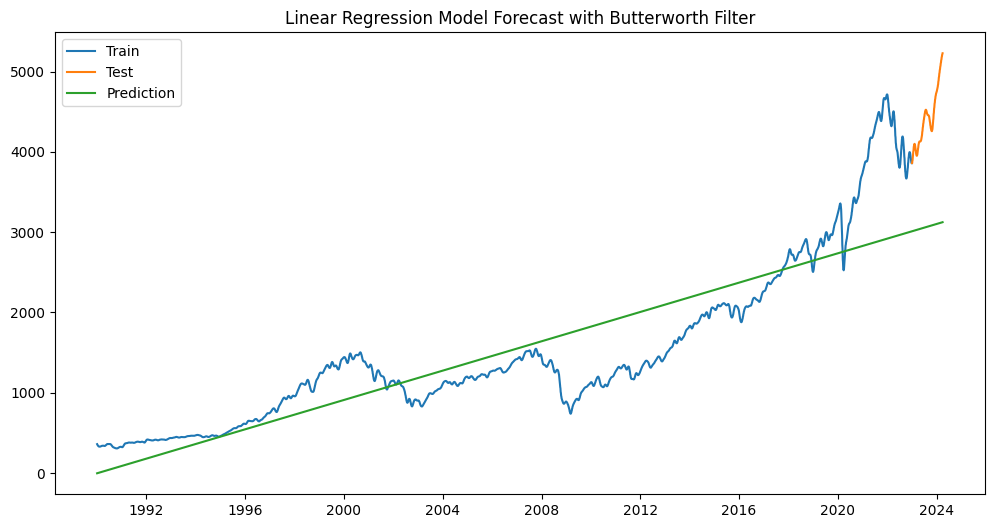

In [6]:
train_series, test_series = load_data(apply_filter=True, debug=True)
print(len(test_series))
predictions = generate_predictions(train_series, test_series, debug=True, start=train_series.index[0], end=test_series.index[-1])
error = get_mse(predictions, test_series)

print(f"MSE: {error}")
plot_predictions(test_series, predictions, title="Linear Regression model with Butterworth Filter")
plot_full_series(train_series, test_series, predictions, title="Linear Regression Model Forecast with Butterworth Filter")

In [5]:
y = np.array(test_series)
print(len(y))
yp = np.array(predictions)[-len(y):]
print(f'y ---> {y}')
print(f'yp ---> {yp}')
r_matrix = np.corrcoef(y, yp)
print(r_matrix)

324
y ---> [3860.48923215 3864.78457693 3870.41931741 3877.32347121 3885.4088644
 3894.57153007 3904.69452666 3915.6509668  3927.30698427 3939.52435717
 3952.16252874 3965.07986486 3978.13415642 3991.18259378 4004.08166753
 4016.68750324 4028.85687323 4040.44876269 4051.32625139 4061.35857874
 4070.42333655 4078.40876371 4085.21618434 4090.7625929  4094.98316243
 4097.83329103 4099.28993707 4099.35224805 4098.04159054 4095.40110374
 4091.49496094 4086.40748854 4080.24207582 4073.11962626 4065.17635246
 4056.56092254 4047.43113284 4037.95034718 4028.28398803 4018.59636298
 4009.04798974 3999.79344852 3990.97974824 3982.7451894  3975.21866291
 3968.51917804 3962.75521621 3958.023492   3954.40697074 3951.9723408
 3950.76738958 3950.81884231 3952.13110289 3954.68600876 3958.44342809
 3963.34245505 3969.30301833 3976.22776515 3984.00410131 3992.50636725
 4001.59826999 4011.13569804 4020.96995341 4030.95136192 4040.93312886
 4050.77515785 4060.34745491 4069.53281128 4078.22868255 4086.348394

In [20]:
train_series, test_series = load_data(apply_filter=False, debug=True)
np.mean(abs(np.array(test_series)-np.array(predictions)[-324:]))

[*********************100%%**********************]  1 of 1 completed

Data loaded and forward filled. Total rows after forward fill: 8933.


1355.5139183730982

In [21]:
data = {
  "model": "Linear Regression",
  "test_start_date": "2023-01-02",
  "test_end_date": "2024-03-28",
  "mse": 1940992.2951213908,
  "mae": 4369.158523515075,
  "r": 0.923,
  "predictions":predictions.tolist()[-324:],
  "unfiltered_test":test_series.tolist()
}


In [22]:
import json
with open("linear_regression.json",'w') as f:
    f.write(json.dumps(data,indent=4))